# Auto-Encoder Note v2

In [2]:
# import watermark
%reload_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.5.0

numpy 1.14.5
sklearn 0.20.0
scipy 1.1.0
matplotlib 3.0.0
tensorflow 1.10.1


In [3]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import sys
import os

# Custom Modules
import EGJ.utils as utils

# 맷플롯립 설정
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 저장 로드 등에 사용
ROOT_PATH = os.getcwd() + "/EGJ/Autoencoder"

In [4]:
# 데이터 생성
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


# 비지도 사전훈련

<br/>훈련데이터가 많지 않은 복잡한 지도 학습 문제를 다루어야 한다면, 비슷한 문제에 학습된 신경망을 찾아 하위층을 재사용하는 방법이 유용하다. 저수준의 특성을 학습시킬 필요가 없기 때문에 작은 훈련 데이터만 사용하여 고성능 모델을 훈련시킬 수 있다는 장점이 존재한다.

In [5]:
utils.reset_graph()

n_inputs = 28 * 28
n_hiddens = [300, 150]
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hiddens[0]])
weights2_init = initializer([n_hiddens[0], n_hiddens[1]])
weights3_init = initializer([n_hiddens[1], n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hiddens[0]), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hiddens[1]), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [6]:
# 사전훈련이 없는 평범한 훈련
import numpy.random as rnd

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "검증 세트 정확도:", accuracy_val, end=" ")
        utils.save_tf(sess, "note/supervied_normal/model")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

0 검증 세트 정확도: 0.93333334 

테스트 정확도: 0.9191
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

1 검증 세트 정확도: 0.97333336 

테스트 정확도: 0.9371
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

2 검증 세트 정확도: 0.9866667 

테스트 정확도: 0.9318
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

3 검증 세트 정확도: 0.97333336 

테스트 정확도: 0.9404


In [9]:
# 사전 훈련된 오토인코더 이용; 첫 번째와 두 번째의 은닉층을 재사용
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

# layers 1와 2를 동결 (선택사항)
# training_op = optimizer.minimize(loss, var_list=[weights3, biases3])

with tf.Session() as sess:
    init.run()
    utils.load_pre_tf(var_list=[weights1, weights2, biases1, biases2], sess=sess, file_name="note/stack_weights_each/model_cached_frozen", root_path=ROOT_PATH)
    
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "훈련 정확도:", accuracy_val, end="\t")
        utils.save_tf(sess, "note/supervied_pretrained/model", root_path=ROOT_PATH)
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stack_weights_each/model_cached_frozen.ckpt


0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

0 훈련 정확도: 0.94666666	

테스트 정확도: 0.9218
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

1 훈련 정확도: 0.96	

테스트 정확도: 0.9388
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

2 훈련 정확도: 0.9533333	

테스트 정확도: 0.9413
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

3 훈련 정확도: 0.9866667	

테스트 정확도: 0.9409


# Stacked Denoising Auto-Encoder; 적층 잡음제거 오토인코더

<br/>가우시안(Gaussian) 잡음 또는 다롭아웃 방지

In [7]:
utils.reset_graph()

n_inputs = 28 * 28
n_hiddens = [300, 150, 300]
n_outputs = n_inputs

learning_rate = 0.01

In [8]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hiddens[0], activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hiddens[1], activation=tf.nn.relu, # 책에는 없음
                          name="hidden2")                            # 책에는 없음
hidden3 = tf.layers.dense(hidden2, n_hiddens[2], activation=tf.nn.relu, # 책에는 없음
                          name="hidden3")                            # 책에는 없음
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # 책에는 없음

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

In [13]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
            
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        utils.save_tf(sess, "note/stacked_denoising_gaussian/model", root_path=ROOT_PATH)

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.04444995


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.038391314


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.043686826


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.04251602


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 훈련 MSE: 0.041144673


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 훈련 MSE: 0.04154353


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 훈련 MSE: 0.04288338


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 훈련 MSE: 0.04026481


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 훈련 MSE: 0.04345547


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 훈련 MSE: 0.04263062


In [10]:
# 드롭아웃 사용
utils.reset_graph()

n_inputs = 28 * 28
n_hiddens = [300, 150, 300]
n_outputs = n_inputs

learning_rate = 0.01

In [11]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hiddens[0], activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hiddens[1], activation=tf.nn.relu, # 책에는 없음
                          name="hidden2")                            # 책에는 없음
hidden3 = tf.layers.dense(hidden2, n_hiddens[2], activation=tf.nn.relu, # 책에는 없음
                          name="hidden3")                            # 책에는 없음
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # 책에는 없음

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, training: True})
            
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        utils.save_tf(sess, "note/stacked_denoising_dropout/model", root_path=ROOT_PATH)

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.035083987


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.027697109


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.029508727


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.027227374


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 훈련 MSE: 0.026625771


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 훈련 MSE: 0.025953436


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 훈련 MSE: 0.027059395


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 훈련 MSE: 0.025359934


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 훈련 MSE: 0.027301932


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 훈련 MSE: 0.027201267


INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stacked_denoising_dropout/model.ckpt


/Users/eugene/.venv/python3.6.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


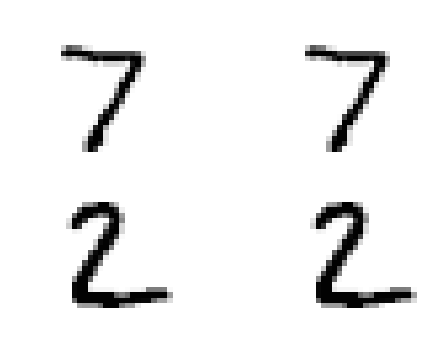

In [13]:
utils.show_reconstructed_digits(outputs, X, X_test, "note/stacked_denoising_dropout/model", root_path=ROOT_PATH)